In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import sigma_clipped_stats
from astropy.stats import sigma_clip
import matplotlib
import seaborn as sns
import processing_functions as pf
import scipy.stats as stats
import scipy.special as sps
import scipy.optimize as opt
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [4]:
lc1 = 'data-0.1s/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q1.lc'
lc1_data = fits.open(lc1)[1].data
max_1 = int(np.where(lc1_data['RATE'] == np.max(lc1_data['RATE']))[0])
start = max_1-1100
end = max_1+220

In [5]:
data, south_atlantic_start, south_atlantic_end = pf.filter_and_detrend(lc1, start, end, 3)
if end<south_atlantic_start:
    total_noise = np.concatenate((data['RATE'][:start], data['RATE'][end:south_atlantic_start], data['RATE'][south_atlantic_end:]))
elif start>south_atlantic_end:
    total_noise = np.concatenate((data['RATE'][:south_atlantic_start], data['RATE'][south_atlantic_end:start], data['RATE'][end:]))
else:
    print('Inputted start and end times are not valid')
    snr = 0
    total_noise = 0
    popt = [0]
    bin_center = 0

In [18]:
i=0
while i<1000:
    params = stats.gamma.fit(total_noise)
    k = params[0]
    loc = params[1]
    theta = params[2]
    mean = np.mean(total_noise)
    diff = k*theta - mean
    if np.round(diff, 0)==0: break
    total_noise += diff
    i+=1

47.02313836281566 4.984486384735721 0.0653085434189169


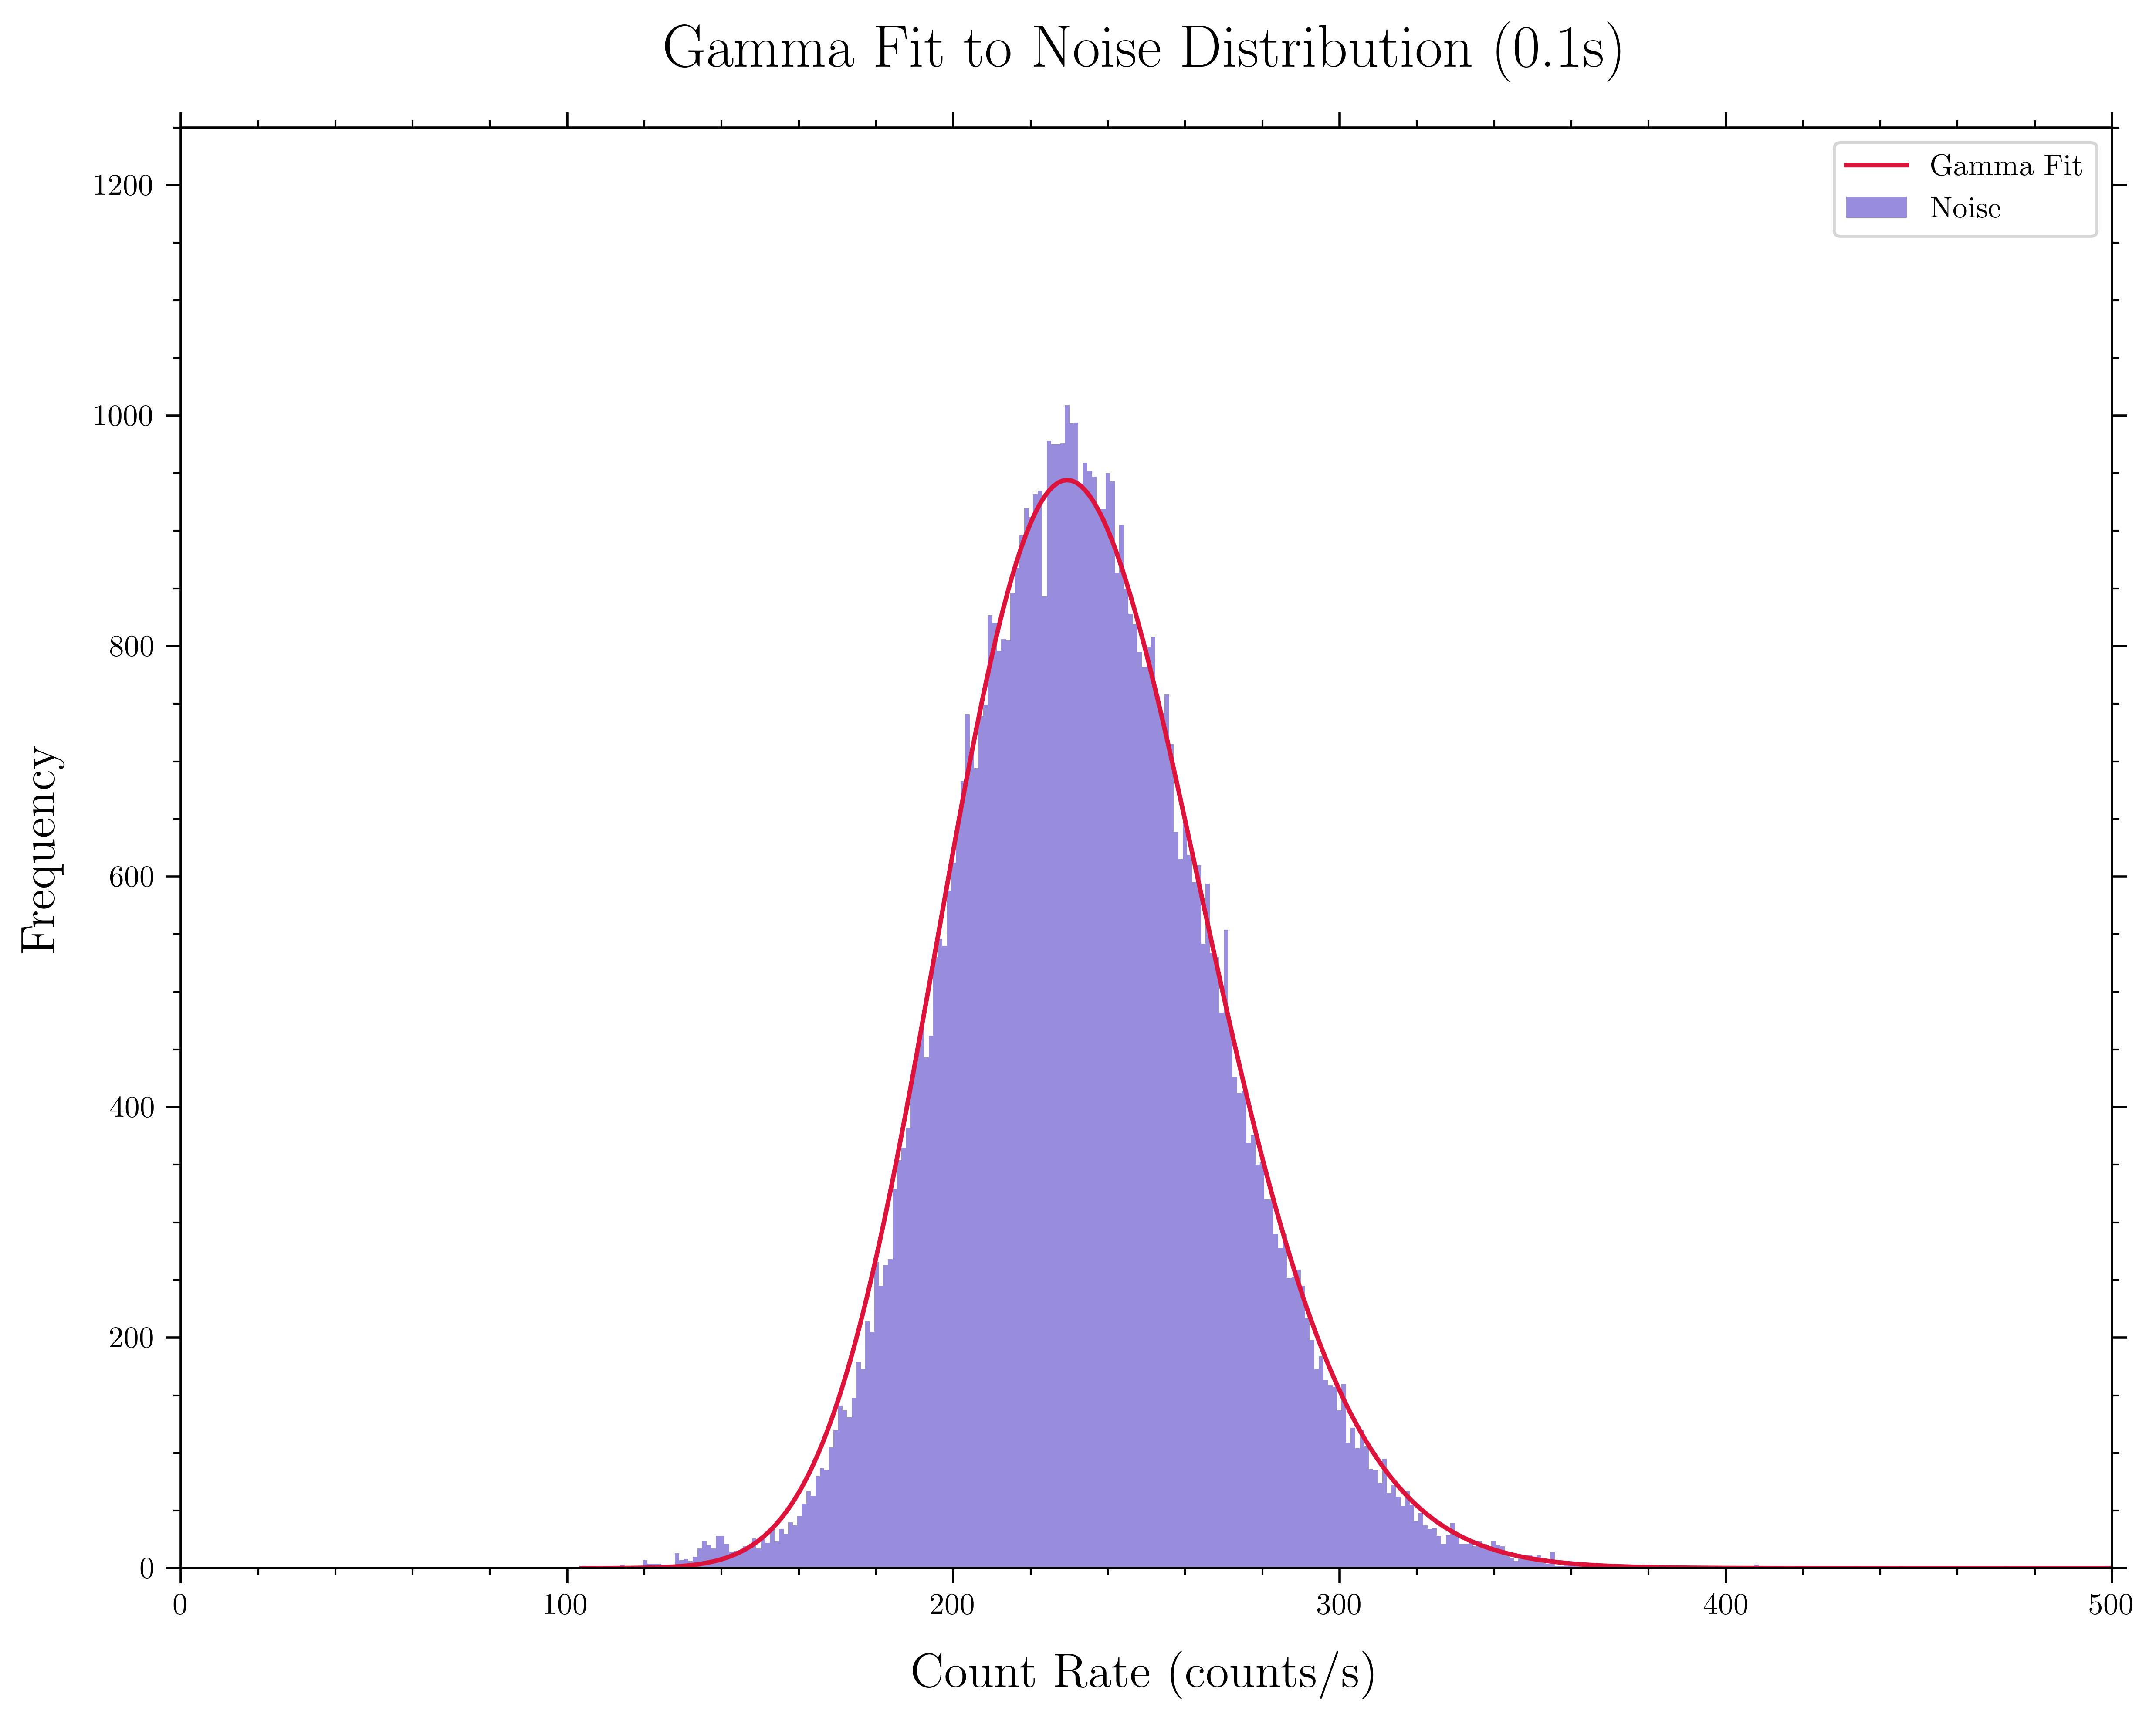

In [17]:
# params = stats.gamma.fit(total_noise)
# k = params[0]
# theta = params[2]
# loc=params[1]
n, bins = np.histogram(total_noise, bins=500)
bin_center = np.array([0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)])
def y(x, c):
    return c*stats.gamma.pdf(x, k, loc=loc, scale=theta)
popt, pcov = opt.curve_fit(y, bin_center, n)

print(k, theta, loc)
plt.figure(figsize=(10, 8), dpi=500)
# plt.plot(bin_center, y, label='Gamma fit', color='red')
plt.plot(bin_center, y(bin_center, popt[0]), label='Gamma fit', color='crimson')
plt.hist(total_noise, bins=bins, label='Noise', color='slateblue', alpha=0.69)
plt.xlim(0,500)
plt.ylim(0, 1250)
plt.title('Gamma Fit to Noise Distribution (0.1s)', fontsize=20, pad=20)
plt.xlabel('Count Rate (counts/s)', fontsize=16, labelpad=10)
plt.ylabel('Frequency', fontsize=16, labelpad=10)
plt.legend(['Gamma Fit', 'Noise'])
plt.tight_layout()
plt.show()

In [181]:
34.4066377132485*2.0686397063146407

71.17493693440862

In [137]:
def gamma_fit(x, c):
    shape, scale = k, theta
    return c*x**(shape-1)*(np.exp(-x/scale)/(sps.gamma(shape)*scale**shape))

Text(0.5, 1.0, 'Gamma fit to background noise (10s)')

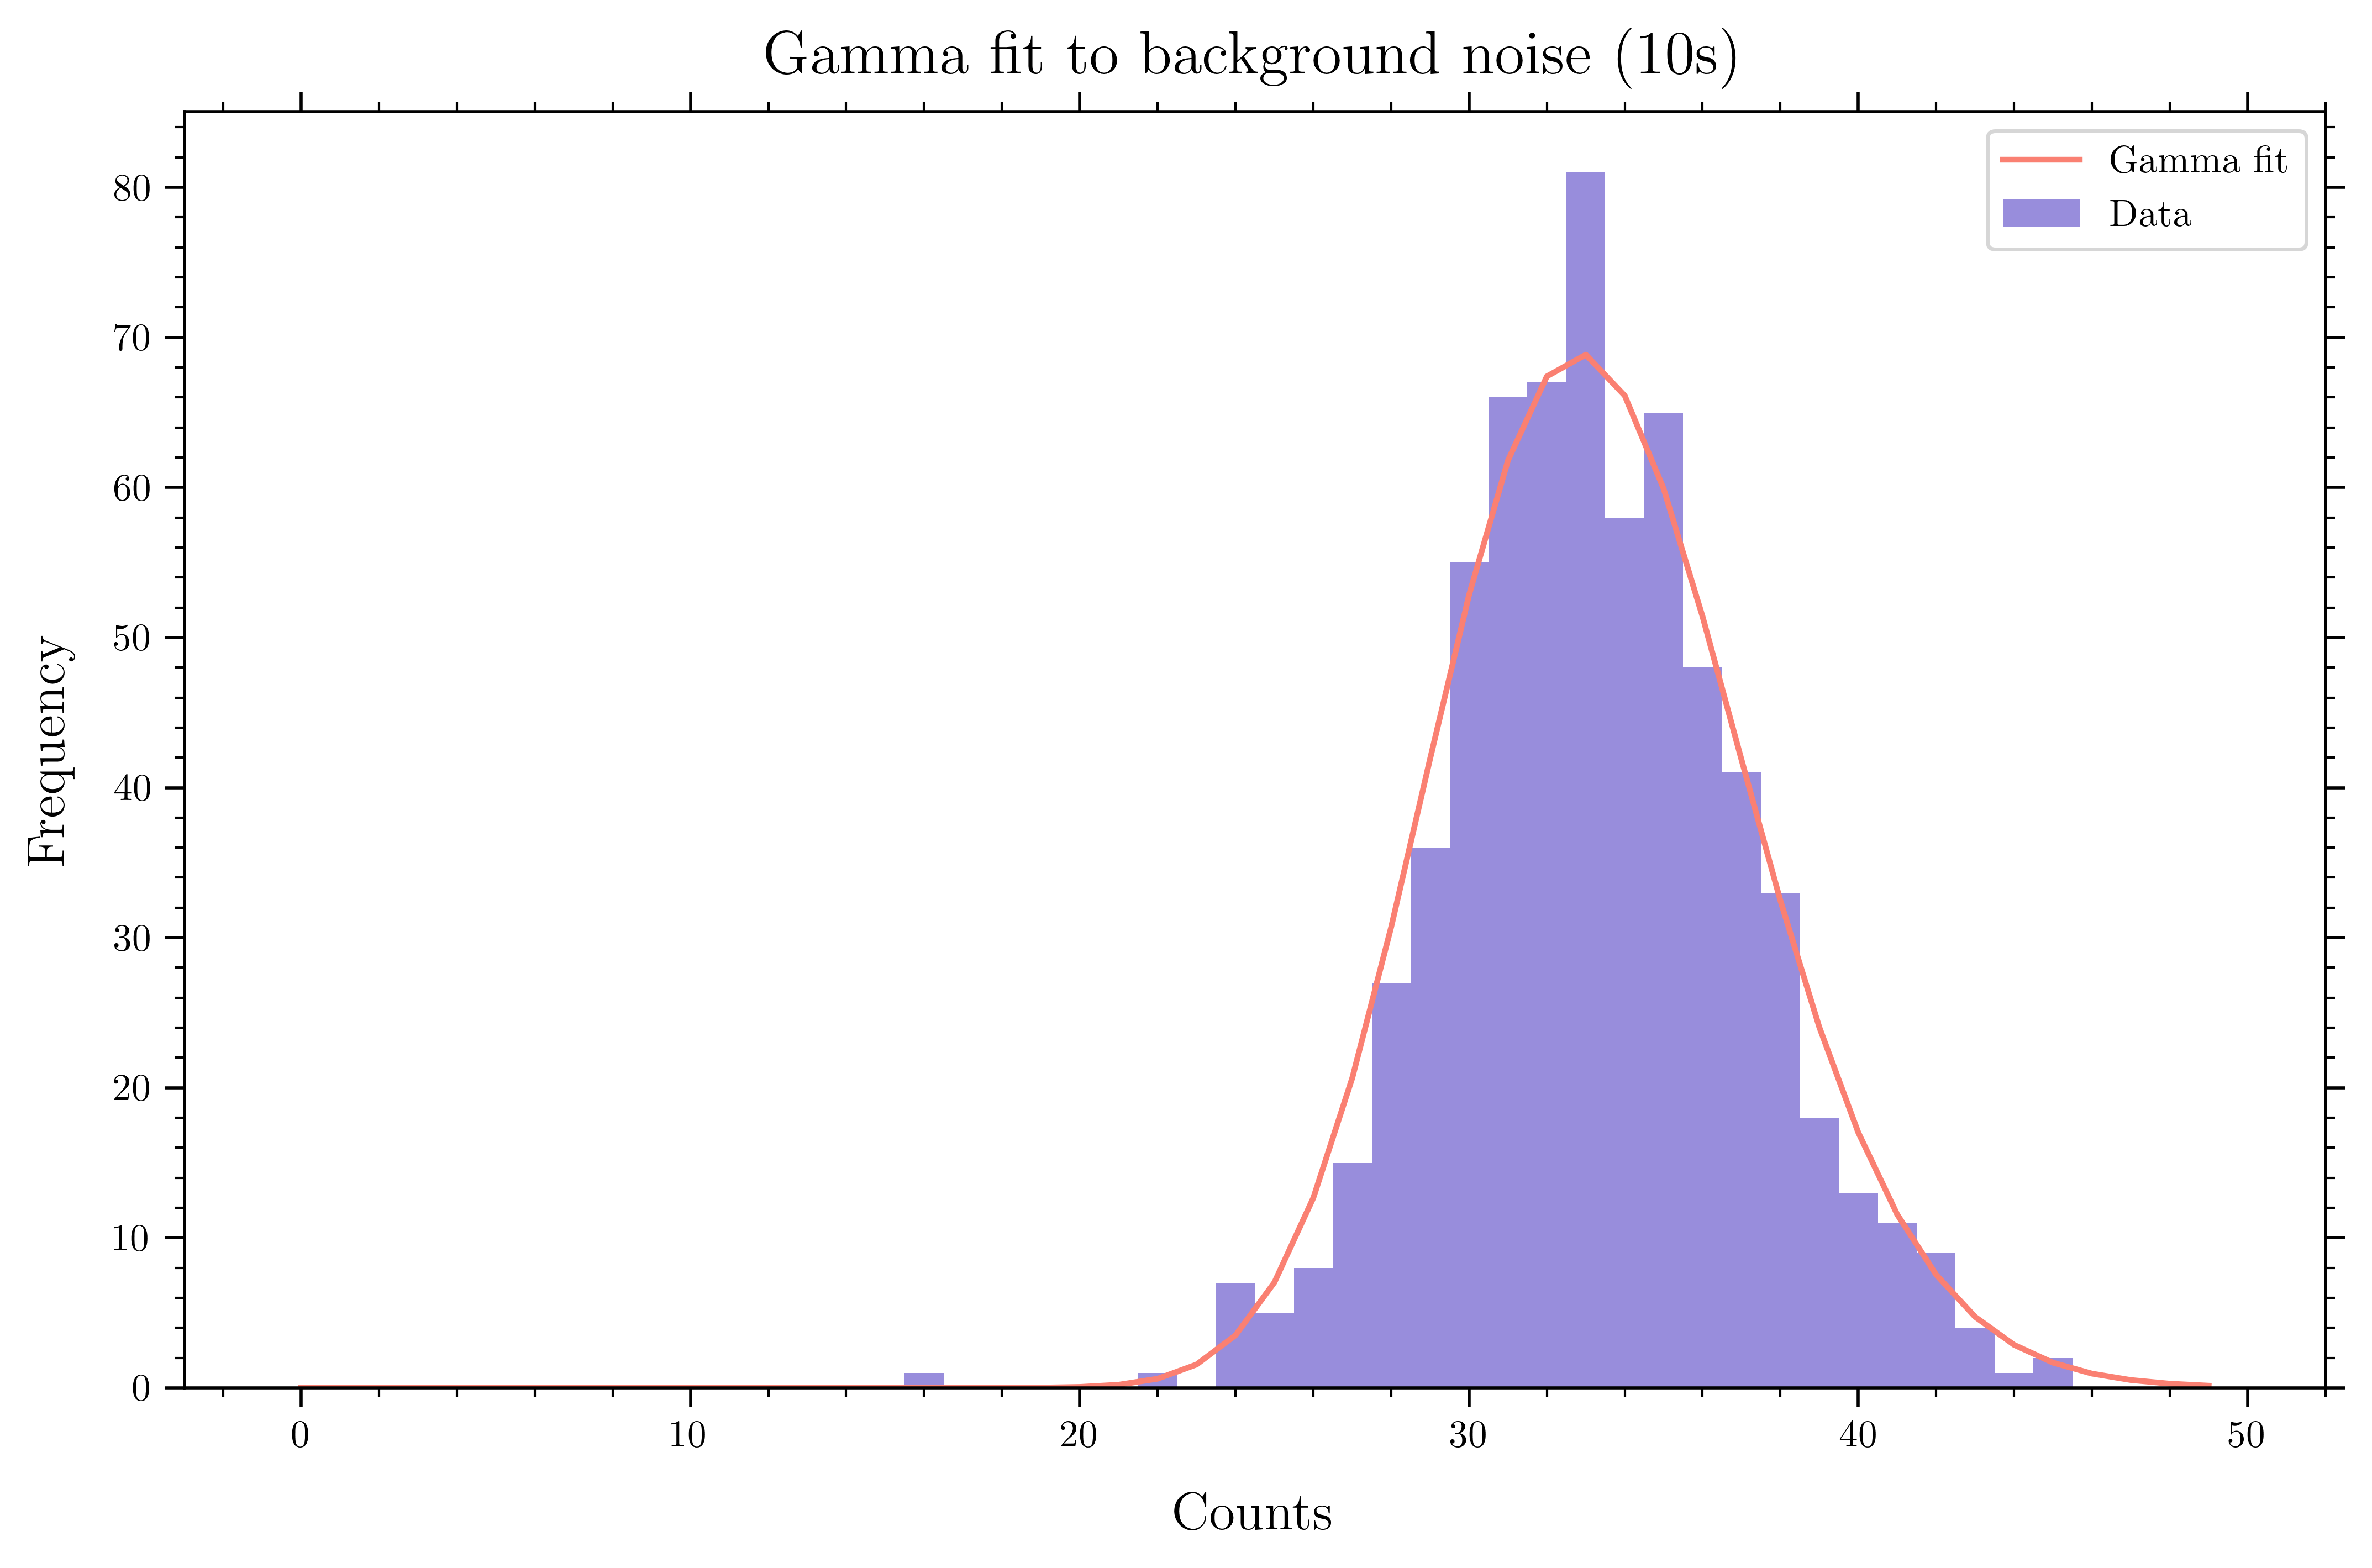

In [119]:
n, bins = np.histogram(total_noise, bins=200)
bin_center = np.array([0.5*(bins[i]+bins[i+1]) for i in range(len(bins)-1)])
popt, pcov = opt.curve_fit(gamma_fit, bin_center, n)

plt.figure(figsize=(10, 6), dpi=500)
plt.hist(total_noise, bins=200, color='slateblue', label='Data', alpha=0.69)
plt.plot(bin_center, gamma_fit(bin_center, *popt), color='salmon', label='Gamma fit')
plt.legend()
plt.xlabel('Counts', labelpad=10, fontsize=14)
plt.ylabel('Frequency', labelpad=10, fontsize=14)
plt.title('Gamma fit to background noise', pad=10, fontsize=16)

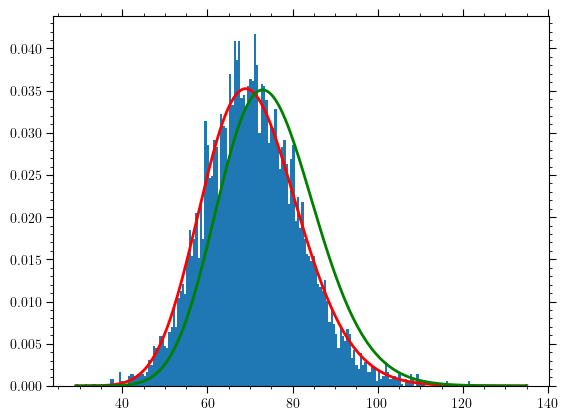

In [76]:
# params = stats.gamma.fit(total_noise)
# print(params)
# shape = params[0]
# loc = params[1]
# scale = params[2]

# Create 100 bins with existing data.
count, bins, ignored = plt.hist(total_noise, 200, density=True)

# Make continuous function Gamma with parameters derived from existing data.
fig = plt.plot()

# Plot Bins along with continuous function
plt.plot(bins, gamma_fit(bins, 38.259287103657456, 1.8509475268272326), linewidth=2, color='r')


In [23]:
49.1532347147391*1.6344232423823204

80.3371892560431

In [6]:
rsp = fits.open('data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.rsp')
rsp.info()

Filename: data/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.rsp
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  EBOUNDS       1 BinTableHDU     29   512R x 3C   [I, E, E]   
  2  MATRIX        1 BinTableHDU     44   300R x 6C   [E, E, I, J, J, PE(512)]   


260.5

In [63]:
values = np.array([values for values in rsp[2].data['MATRIX']])
mean, median, std = sigma_clipped_stats(values)

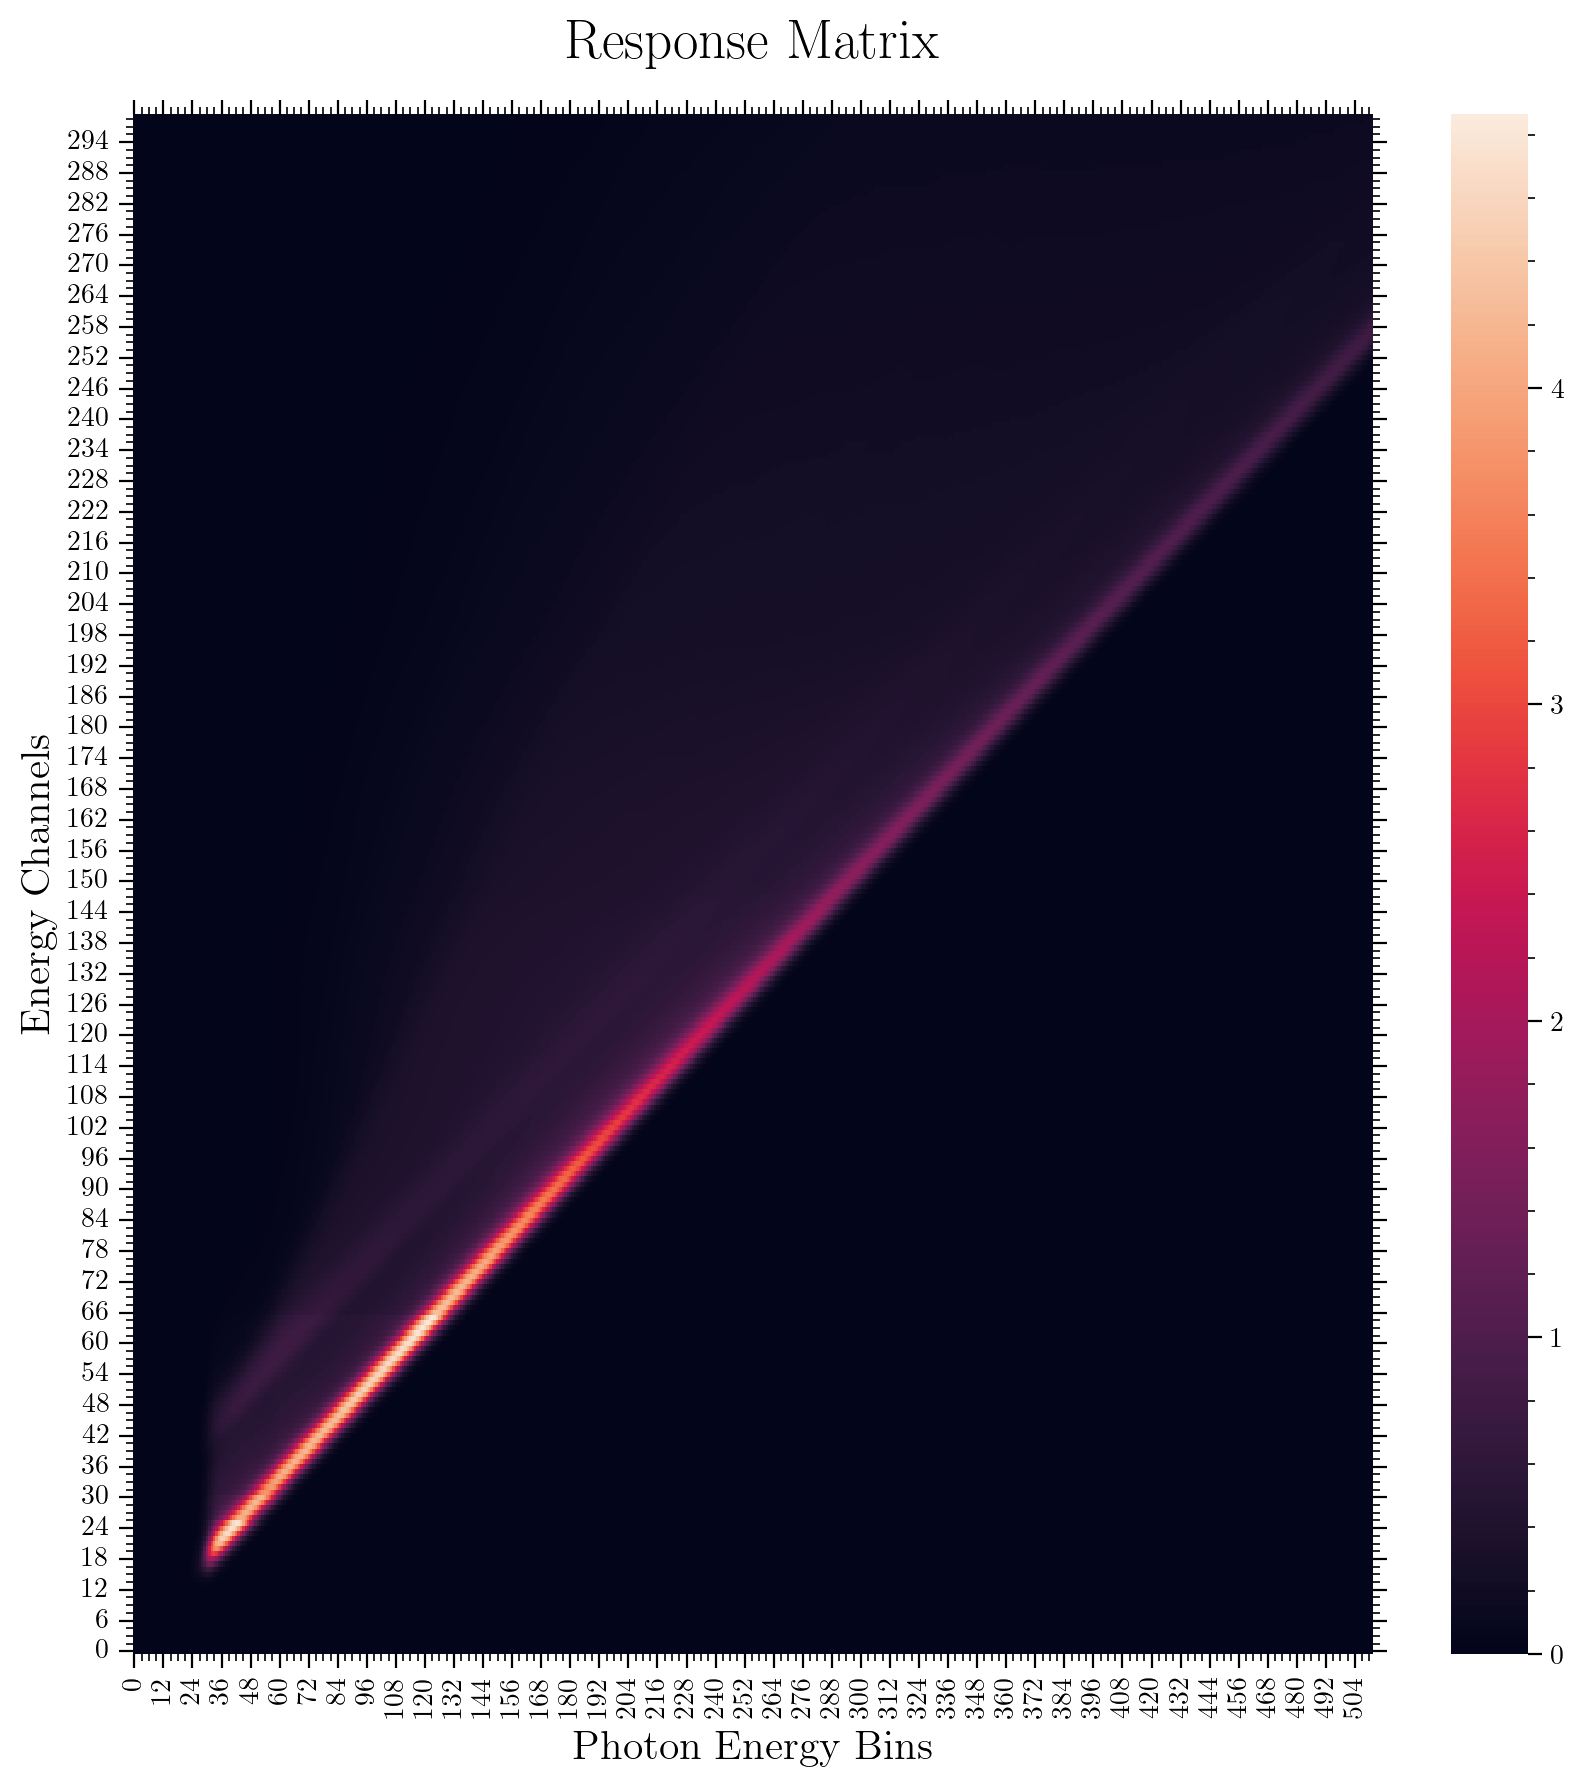

In [88]:
plt.figure(figsize=(10,10), dpi=200)
sns.heatmap(values)
plt.gca().invert_yaxis()
plt.xlabel('Photon Energy Bins', fontsize=15)
plt.ylabel('Energy Channels', fontsize=15)
plt.title('Response Matrix', pad=20, fontsize=20)
plt.show()

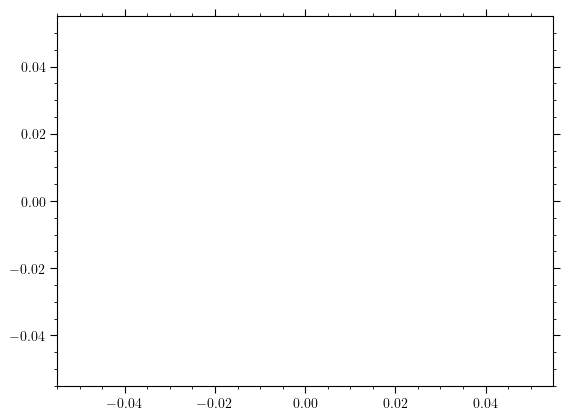

In [2]:
file = fits.open('test/bindata_Q0.lc')
plt.plot(file[1].data['TIME'], file[1].data['RATE'])